# VaR using Monte Carlo Simulation

### Steps to Calculate VaR using Monte Carlo Simulation
1. Collect Historical data
2. Calculate daily log returns
3. Compute mean and standard deviation of the log returns of each company
4. Use Monte Carlo method to simulate future returns based on the mean and std_dev from step 3
5. Compute value of the portfolio for each simulation
6. Determine VaR at the specified confidence level from the simulated portfolio values

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import yfinance as yf 
plt.style.use('seaborn-v0_8-dark-palette') 
import warnings
warnings.filterwarnings('ignore') 

In [2]:
start_date = '2011-01-01' 
end_date = '2019-12-31' 

tickers = ['AAPL','AMD','NVDA','MSFT','TSLA','AMZN'] 

In [3]:
data = pd.DataFrame() 
for tick in tickers:
    data[f'{tick}'] = yf.download(tick,start=start_date,end=end_date)['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


#### Calculate log returns

In [4]:
log_returns = np.log(data/data.shift(1)).dropna() 
log_returns.head() 

,AAPL,AMD,NVDA,MSFT,TSLA,AMZN
Date,,,,,,
2011-01-04,0.005205,0.034806,-0.003165,0.003924,0.001876,0.004279
2011-01-05,0.008147,0.015837,0.073927,-0.003209,0.005981,0.012942
2011-01-06,-0.000809,-0.025001,0.129622,0.028865,0.038389,-0.008358
2011-01-07,0.007136,0.015982,0.027553,-0.007663,0.012830,-0.001993
2011-01-10,0.018658,0.039961,0.037535,-0.013376,0.007409,-0.004376


#### Number of simulations and Time Horizon

In [5]:
num_sims = 1000
time_horizon = 1    # One day

confidence_level = 0.95

#### Calculate VaR for each stock

In [6]:
VaRs={} 

for tick in tickers:
    mean_return = log_returns[tick].mean() 
    std_return = log_returns[tick].std() 

    # Simulate Future Returns using Monte Carlo
    simulated_returns = np.random.normal(mean_return,std_return,num_sims) 

    # Calculate VaR
    VaR = np.percentile(simulated_returns,(1-confidence_level)*100)
    VaRs[tick] = -VaR 

# Output VaRs for each stock
for tick in tickers:
    print(f'Value at Risk for {tick} at {confidence_level*100}% confidence level : ${VaRs[tick]:.2f}') 

Value at Risk for AAPL at 95.0% confidence level : $0.03
Value at Risk for AMD at 95.0% confidence level : $0.06
Value at Risk for NVDA at 95.0% confidence level : $0.04
Value at Risk for MSFT at 95.0% confidence level : $0.02
Value at Risk for TSLA at 95.0% confidence level : $0.05
Value at Risk for AMZN at 95.0% confidence level : $0.03


VaR is value at risk per dollar. If you want to invest 1000 dollars in AAPL stock, then your VaR is 
$$Total VaR = VaR * Amount\; to\; invest = 0.02*1000 = 20\$ $$

#### Plot the distribution of simulated returns for each stock

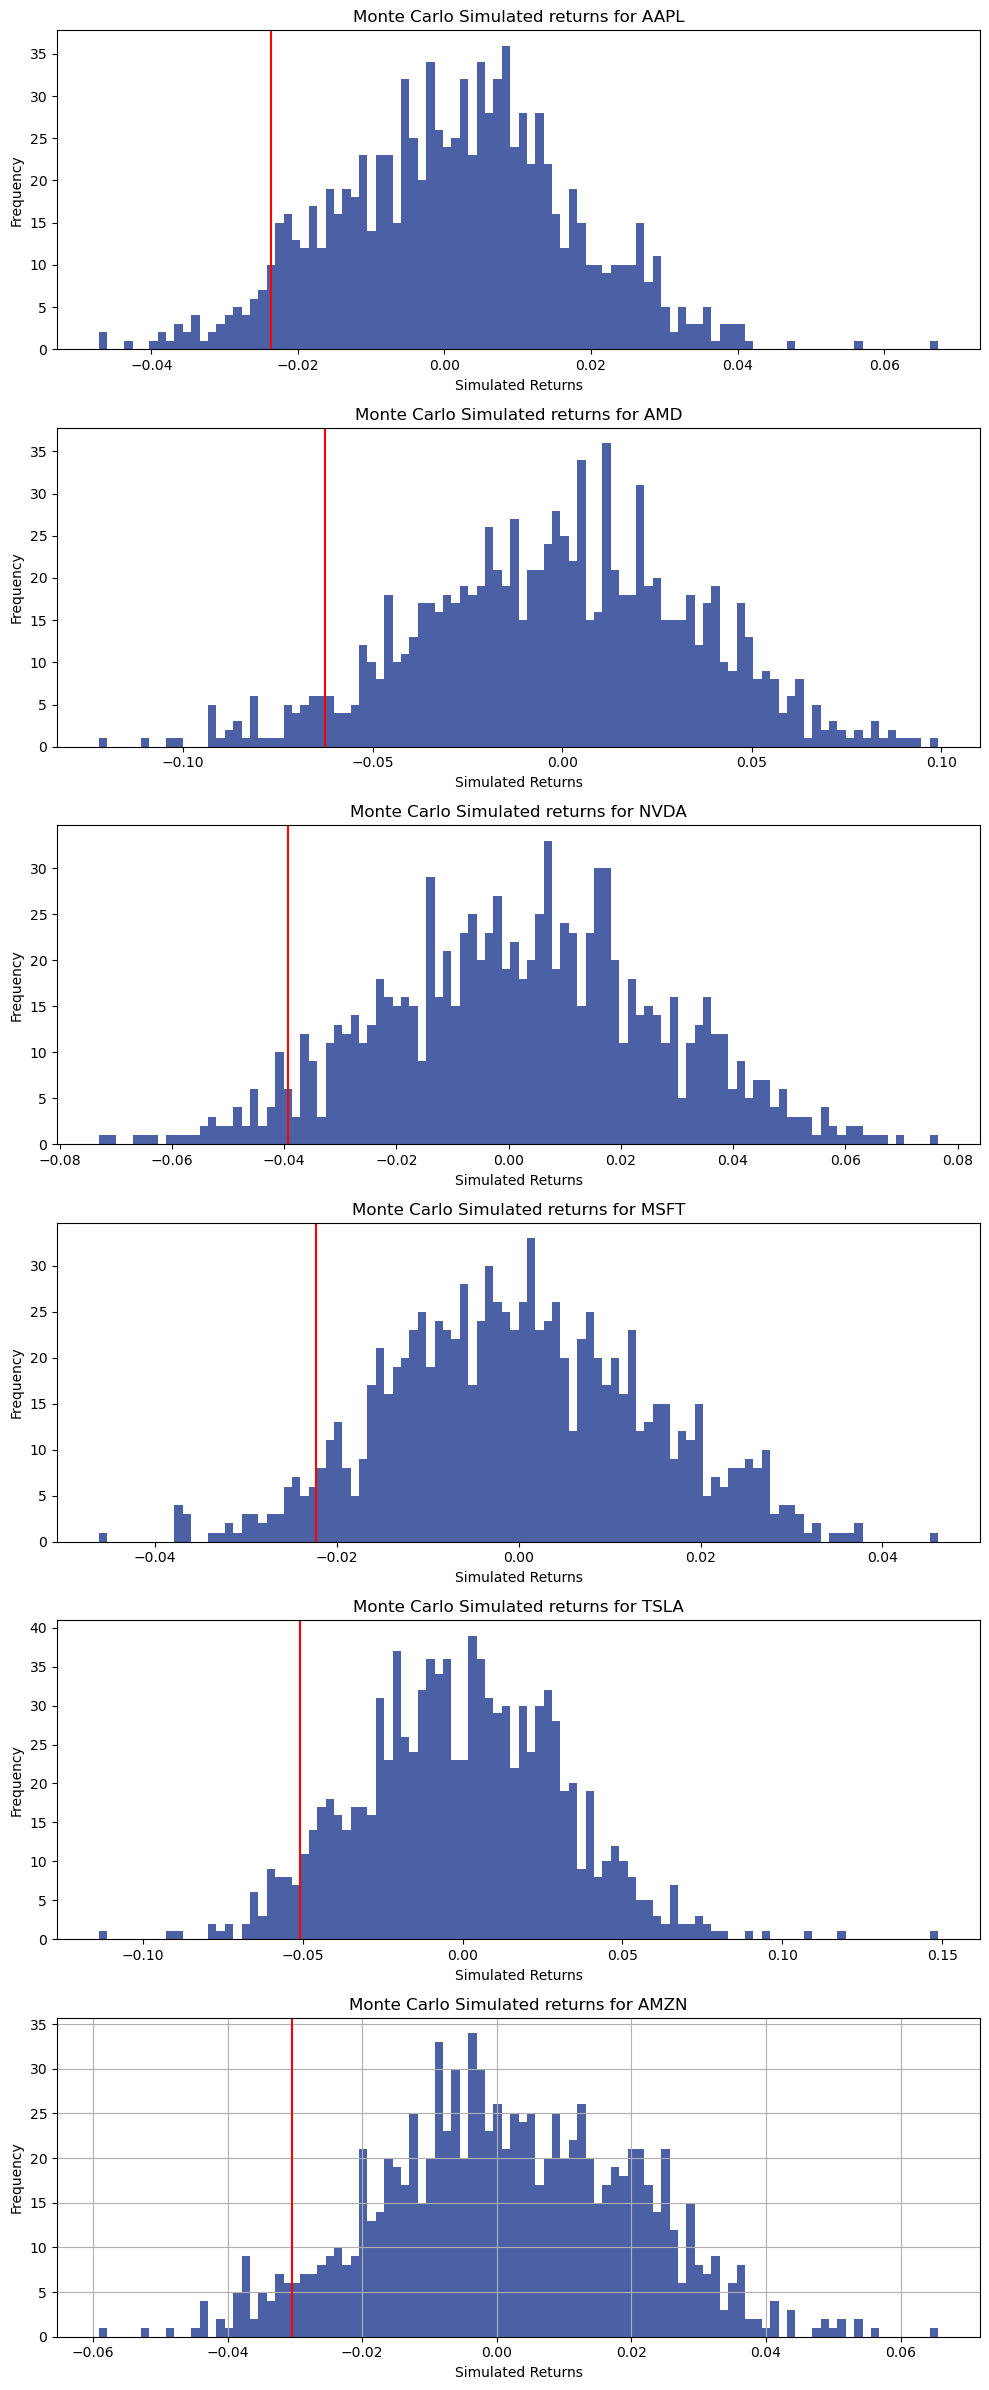

In [7]:
fig, axs = plt.subplots(len(tickers),1,figsize=(10,len(tickers)*4))

for i,tick in enumerate(tickers):
    mean_return = log_returns[tick].mean()
    std_return = log_returns[tick].std() 

    simulated_returns = np.random.normal(mean_return,std_return,num_sims)

    axs[i].hist(simulated_returns,bins=100,alpha=0.7)
    axs[i].axvline(np.percentile(simulated_returns,(1-confidence_level)*100),color='r',linestyle='-')
    axs[i].set_title(f'Monte Carlo Simulated returns for {tick}') 
    axs[i].set_xlabel('Simulated Returns') 
    axs[i].set_ylabel('Frequency') 
    plt.grid(True)

plt.tight_layout()
plt.show() 

VaR calculated corresponds to the maximum expected loss over a given time period (here, 1 day) at a specified level of confidence level.

* Monte Carlo assumes that the returns are normally distributed based on the historic mean and standard deviation. If returns are not normally distributed, VaR may not be accurate

#### Predicting Value for Next Day

Predicting value for next day using historical data and Monte-Carlo involves generating distribution of possible future returns (what we did above) and then applying these returns to the current price 

1. Collect Historical Data
2. Calculate Log Returns
3. Calculate mean and cov
4. Use Monte Carlo to simulate possible returns for the next day
5. Apply simulated returns to the current price to get a possible distribution of possible next day prices
6. Analyze predictions using metrics like mean, median and percentiles

In [8]:
data.head() 

,AAPL,AMD,NVDA,MSFT,TSLA,AMZN
Date,,,,,,
2011-01-03,9.951283,8.47,0.362763,21.585314,1.774667,9.2110
2011-01-04,10.003216,8.77,0.361617,21.670179,1.778000,9.2505
2011-01-05,10.085045,8.91,0.389363,21.600740,1.788667,9.3710
2011-01-06,10.076892,8.69,0.443250,22.233334,1.858667,9.2930
2011-01-07,10.149054,8.83,0.455633,22.063620,1.882667,9.2745


In [9]:
log_returns.head() 

,AAPL,AMD,NVDA,MSFT,TSLA,AMZN
Date,,,,,,
2011-01-04,0.005205,0.034806,-0.003165,0.003924,0.001876,0.004279
2011-01-05,0.008147,0.015837,0.073927,-0.003209,0.005981,0.012942
2011-01-06,-0.000809,-0.025001,0.129622,0.028865,0.038389,-0.008358
2011-01-07,0.007136,0.015982,0.027553,-0.007663,0.012830,-0.001993
2011-01-10,0.018658,0.039961,0.037535,-0.013376,0.007409,-0.004376


In [10]:
predictions = {} 

for tick in tickers:
    mean_return = log_returns[tick].mean() 
    std_return = log_returns[tick].std() 

    # Simulate future returns using Monte Carlo
    simulated_returns = np.random.normal(mean_return,std_return,num_sims) 

    # predict Next Day Price
    current_price = data[tick].iloc[-1]  # Get last available price
    predicted_prices = current_price*np.exp(simulated_returns)

    predictions[tick] = predicted_prices    

#### Analyze Predictions

Predictions for AAPL
Mean Predicted Price : $70.90
Median Predicted Price : $70.90
95% Confidence Interval : $(68.64,72.97)



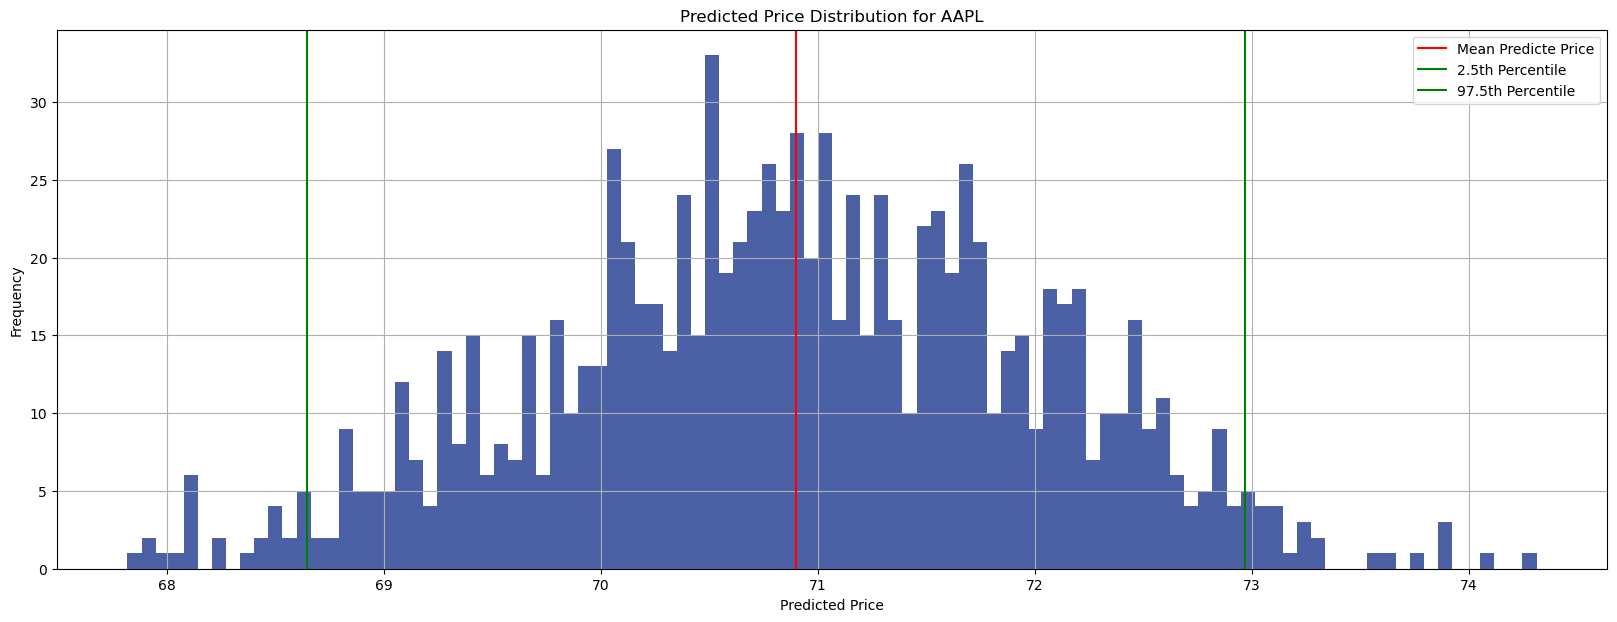

Predictions for AMD
Mean Predicted Price : $45.50
Median Predicted Price : $45.37
95% Confidence Interval : $(42.41,48.91)



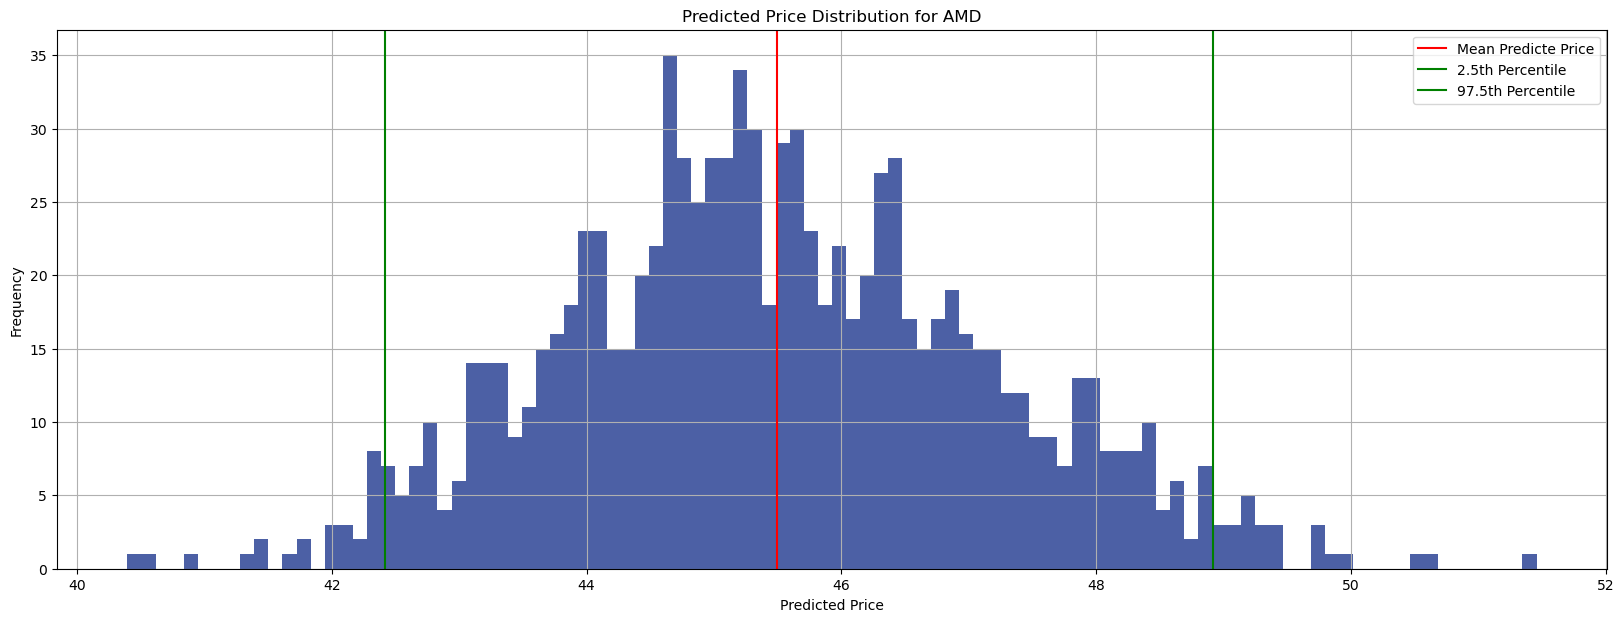

Predictions for NVDA
Mean Predicted Price : $5.79
Median Predicted Price : $5.79
95% Confidence Interval : $(5.50,6.07)



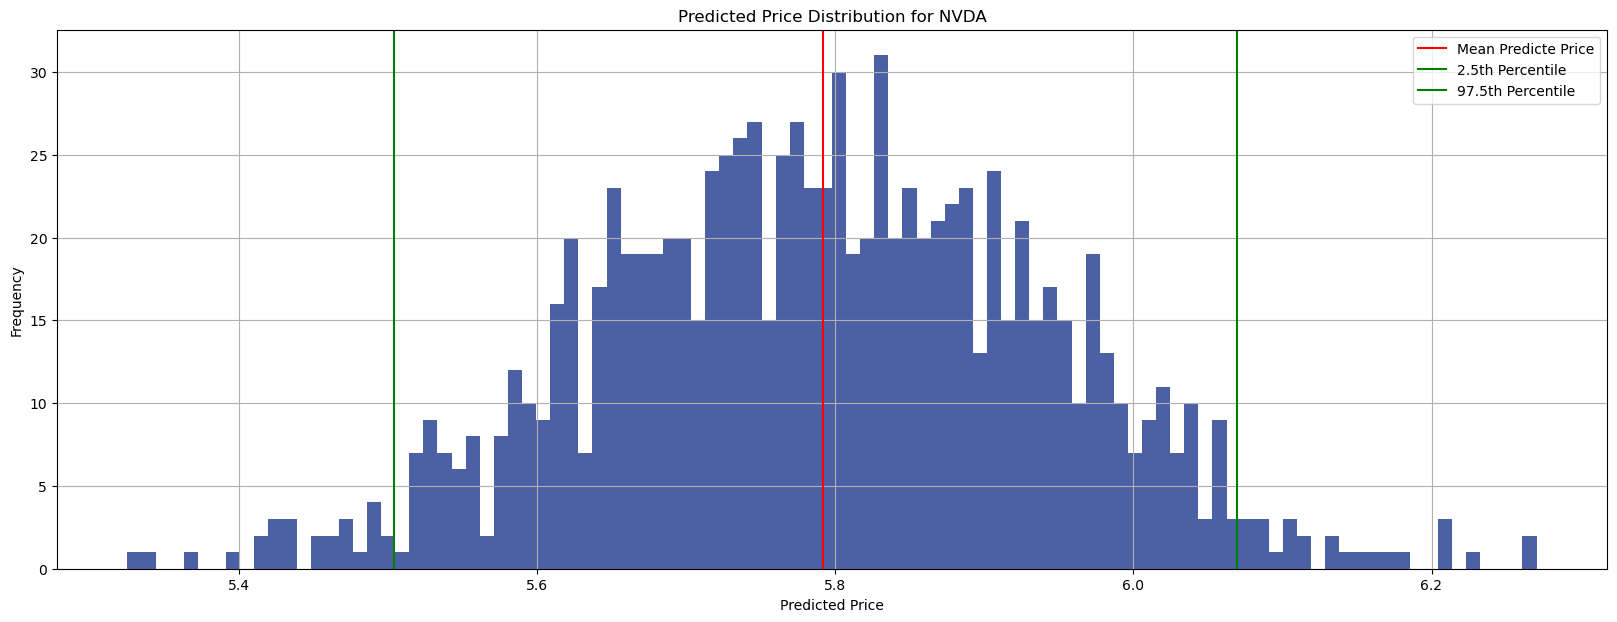

Predictions for MSFT
Mean Predicted Price : $151.57
Median Predicted Price : $151.53
95% Confidence Interval : $(147.22,155.99)



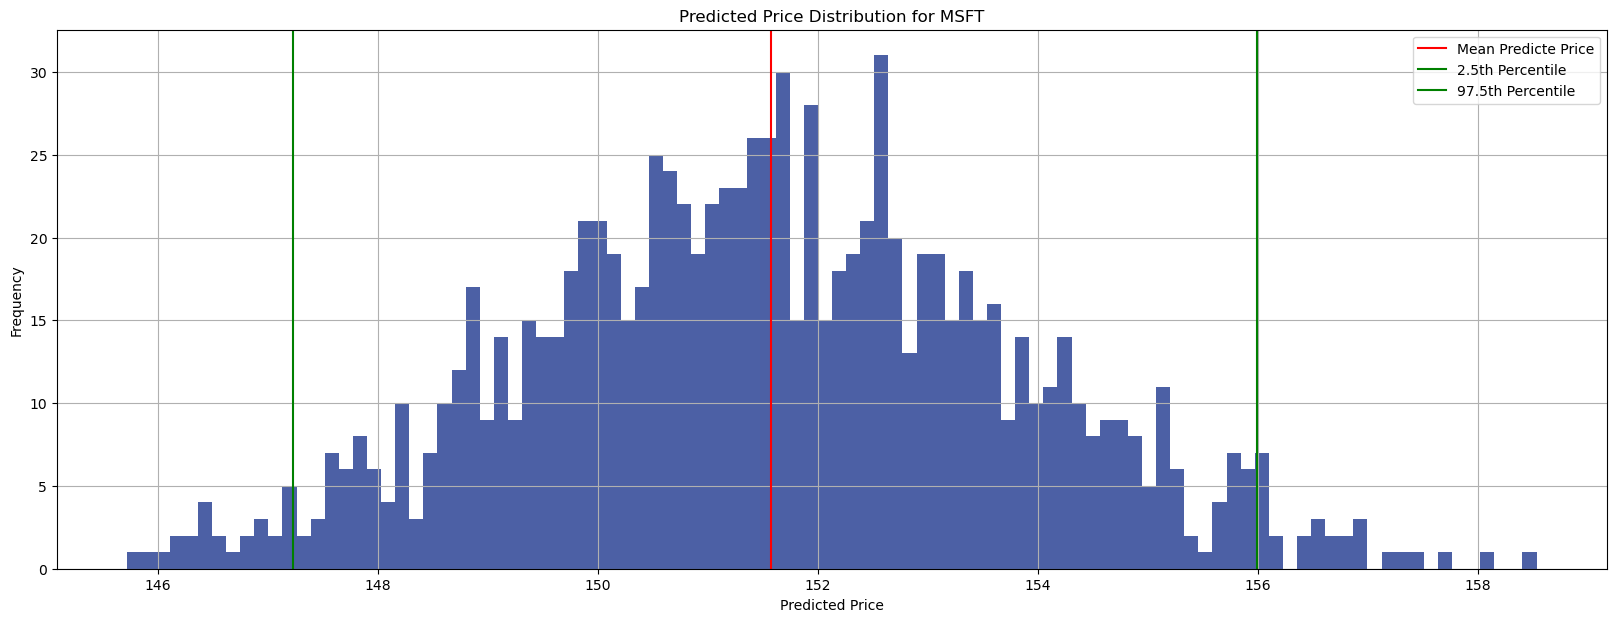

Predictions for TSLA
Mean Predicted Price : $27.68
Median Predicted Price : $27.69
95% Confidence Interval : $(26.02,29.56)



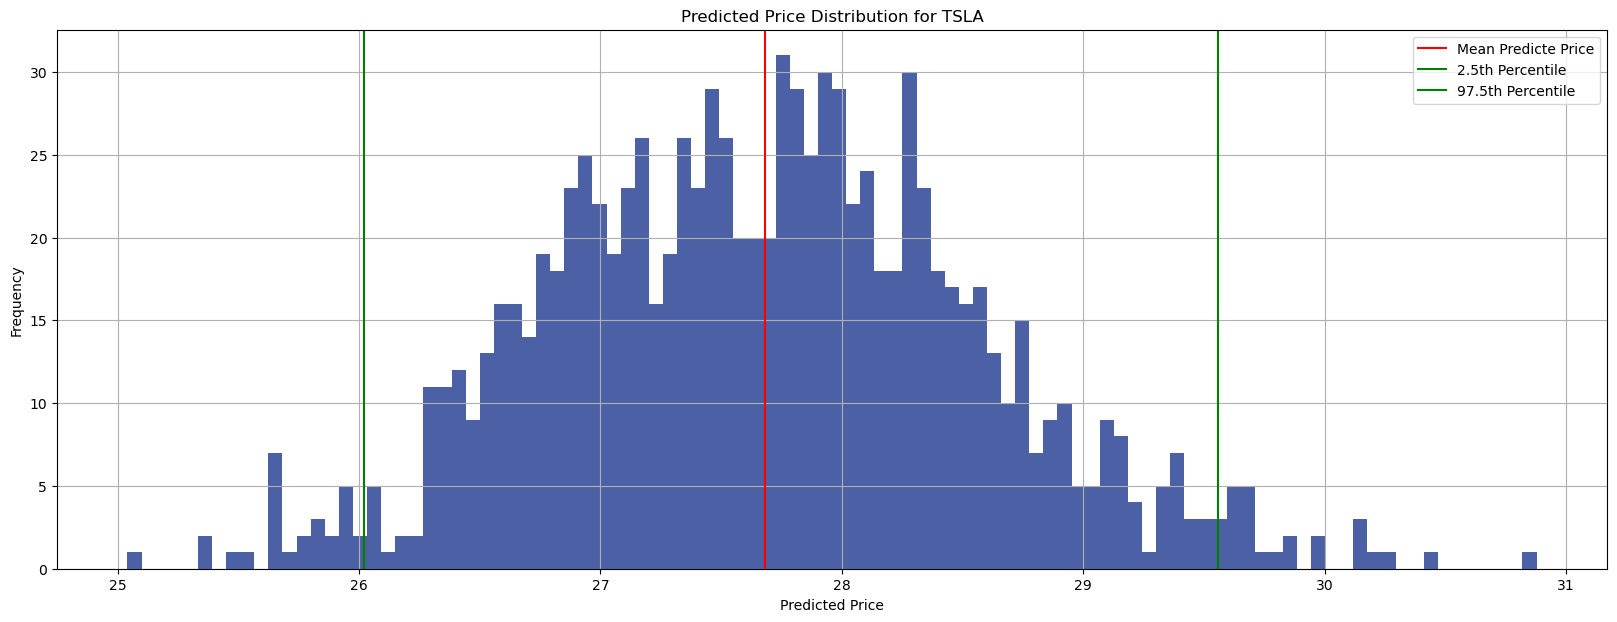

Predictions for AMZN
Mean Predicted Price : $92.42
Median Predicted Price : $92.45
95% Confidence Interval : $(88.95,96.01)



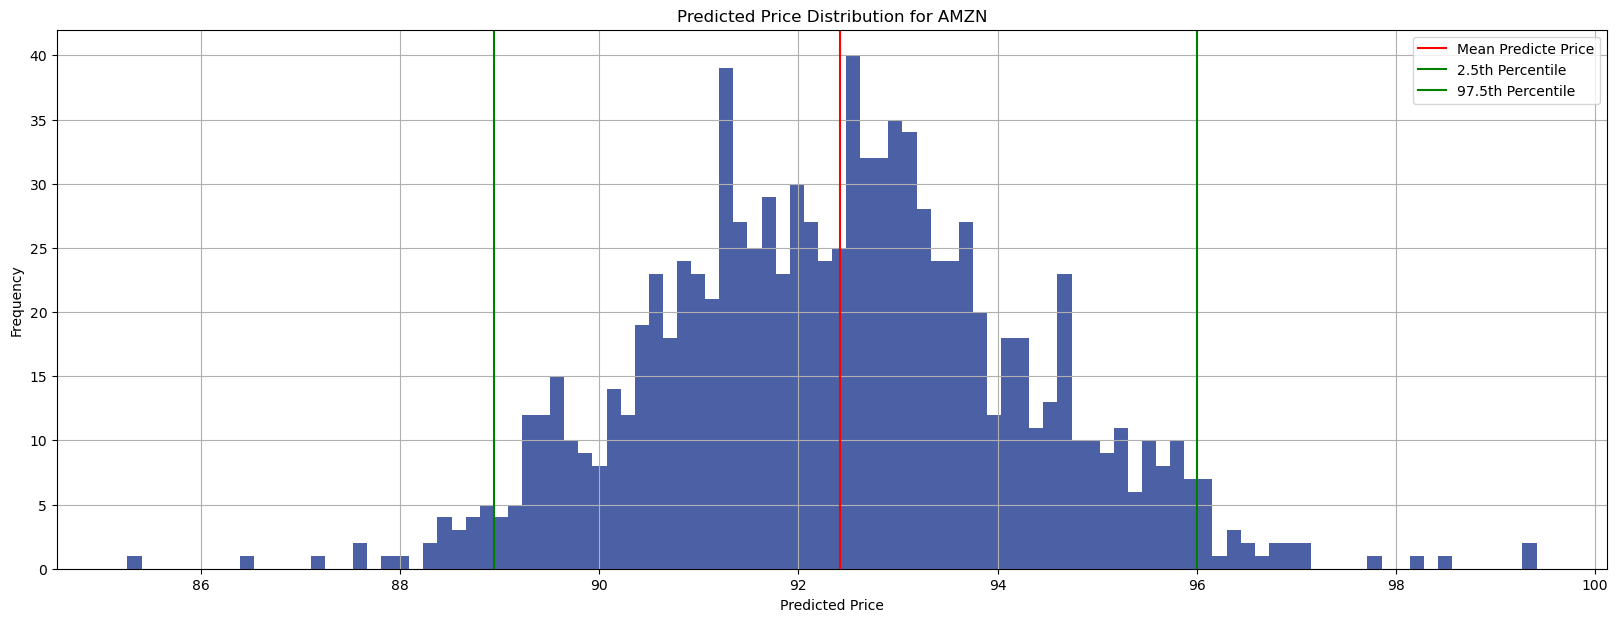

In [11]:
for tick in tickers:
    predicted_prices = predictions[tick] 
    mean_price = np.mean(predicted_prices)
    median_price = np.median(predicted_prices) 
    lower_percentile = np.percentile(predicted_prices,2.5) 
    upper_percentile = np.percentile(predicted_prices,97.5) 
    
    print(f'Predictions for {tick}')
    print(f'Mean Predicted Price : ${mean_price:.2f}') 
    print(f'Median Predicted Price : ${median_price:.2f}') 
    print(f'95% Confidence Interval : $({lower_percentile:.2f},{upper_percentile:.2f})') 
    print() 

    # Plot the distribution of predicted prices
    plt.figure(figsize=(20,7)) 
    plt.hist(predicted_prices,bins=100,alpha=0.7)
    plt.axvline(mean_price,color='r',linestyle='-',label='Mean Predicte Price') 
    plt.axvline(lower_percentile,color='g',linestyle='-',label='2.5th Percentile') 
    plt.axvline(upper_percentile,color='g',linestyle='-',label='97.5th Percentile') 
    plt.title(f'Predicted Price Distribution for {tick}')
    plt.xlabel('Predicted Price')
    plt.ylabel('Frequency')    
    plt.legend(loc='best')
    plt.grid(True)
    plt.show() 

Optimizing portfolio based on predicted future prices involves allocating the portfolio weights to maximize expected returns or minimize risk or achieving a balance between the two.

* Here, we will use mean-variance optimization approach (Markowitz) which balances expected returns and risk

#### Steps to Optimize the Portfolio
1. From simulated future prices, calculate predicted returns for each stock
2. Calculate Covariance matrix of these predicted returns
3. Set up the objective function to maximize the expected return or minimize the portfolio variance
4. Use constraints to ensure portfolio wights sum to 1
5. Use optimization techniques such as quadratic programming to find the optimal weights 

#### Calculate Predicted Returns and Covariance Matrix

In [12]:
predicted_returns = pd.DataFrame(predictions).pct_change().dropna() 
expected_returns = predicted_returns.mean()
cov_matrix = predicted_returns.cov() 

In [23]:
expected_returns

AAPL    0.000217
AMD     0.001382
NVDA    0.000639
MSFT    0.000199
TSLA    0.001006
AMZN    0.000403
dtype: float64

#### Define Optimization Problem

In [13]:
def portfolio_performance(weights,mean_returns,cov_matrix):
    returns = np.sum(mean_returns*weights)*time_horizon
    std_dev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix,weights)))
    return returns,std_dev 

def negative_sharpe_ratio(weights,mean_returns,cov_matrix,risk_free_rate=0):
    p_returns, p_std_dev = portfolio_performance(weights,mean_returns,cov_matrix) 
    return -(p_returns-risk_free_rate)/p_std_dev 

Constraints : Sum of weights is 1

In [14]:
constraints = ({'type':'eq','fun':lambda x:np.sum(x)-1})

Bounds for weights : Each weight between 0 and 1

In [15]:
bounds = tuple((0,1) for _ in range(len(tickers)))

Initial guess : Equal Distribution

In [16]:
initial_weights = np.ones(len(tickers))/len(tickers) 

Solve Optimization Problem

In [17]:
from scipy.optimize import minimize 

In [18]:
try:
    optimized_result = minimize(negative_sharpe_ratio,initial_weights,args=(expected_returns,cov_matrix),
                            method='SLSQP',bounds=bounds,constraints=constraints) 
except Exception as e:
    print("An error occurred:", e)     

Extract optimal weights

In [19]:
optimal_weights = optimized_result.x 

Output of optimized weights

In [20]:
for ticker,weight in zip(tickers,optimal_weights):
    print(f'Optimal weight for {ticker} : {weight:.2f}%') 

Optimal weight for AAPL : 0.16%
Optimal weight for AMD : 0.18%
Optimal weight for NVDA : 0.17%
Optimal weight for MSFT : 0.16%
Optimal weight for TSLA : 0.17%
Optimal weight for AMZN : 0.16%


#### Plot Optimal Portfolio Distribution

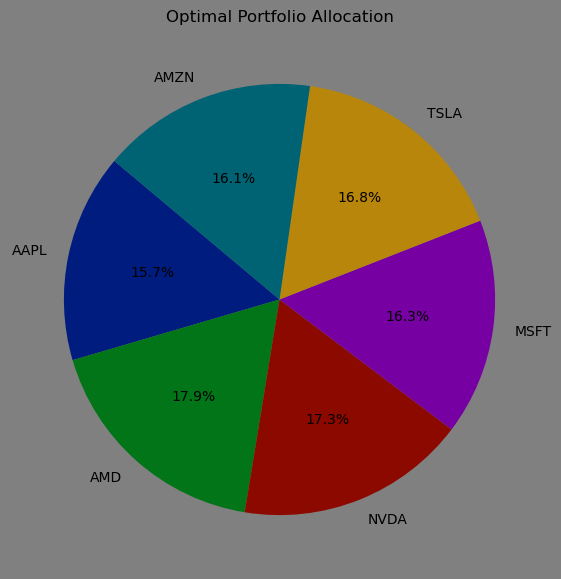

In [21]:
import matplotlib.pyplot as plt

# Plot the optimal portfolio distribution
fig, ax = plt.subplots(figsize=(20, 7))

# Create the pie chart
ax.pie(optimal_weights, labels=tickers, autopct='%1.1f%%', startangle=140)
ax.set_title('Optimal Portfolio Allocation')

# Set the figure and axes background color to white
fig.patch.set_facecolor('grey')
ax.set_facecolor('grey')

plt.show()